# ANOVA

Here, we will run a 2X2 factorial ANOVA on the Boston Marathon data that we cleaned in the cleaning file and explored in the exploratory_data_analysis file.

## Import packages and data

Let's import the packages we will need and import the data to a pandas DataFrame.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns

boston = pd.read_csv('./data/boston_eda.csv')

#Display floats to two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Experiment Setup

Let's bring up size for each group in our data.

In [3]:
boston.groupby(['bq', 'sex']).size().unstack()

sex,0,1
bq,,
0,1246,984
1,1246,1077


While it isn't strictly necessary to have experiment groups of the same size, it will make the ANOVA more robust to departures from the assumption of equal variance. Since we already suspect that we might have unequal variance between groups, let's randomize the runners into four groups of 984.

In [4]:
def experiment_groups(df_in, sample_size, seed):
    """Takes DataFrame, sample size, and seed, returns DataFrame w/ that many random runners from each group."""
    
    ##Use dictionary comprehension to take random sample of n = sample_size runners from each group by sex and bq
    d = {sex: {bq: df_in[(df_in['bq'] == bq) & (df_in['sex'] == sex)].sample(n = sample_size, random_state = seed) 
                   for bq in df_in['bq'].unique()} for sex in df_in['sex'].unique()}
    
    #Concatenate the four DataFrames into one and reset index.
    df_out = pd.concat([d[0][0], d[0][1], d[1][0], d[1][1]])
    df_out.reset_index(drop = True, inplace = True)
    return df_out

boston_exp = experiment_groups(boston, 984, 42)

Let's also create a column that gives a descriptive label for each runner's group membership. This will make it easier to work with the data throughout the experiment.

In [5]:
#Subset data by every combination of bq and sex and assign label to new 'group' column
boston_exp.loc[(boston_exp['bq'] == 0) & (boston_exp['sex'] == 0), 'group'] = 'Women No BQ'
boston_exp.loc[(boston_exp['bq'] == 1) & (boston_exp['sex'] == 0), 'group'] = 'Women BQ'
boston_exp.loc[(boston_exp['bq'] == 0) & (boston_exp['sex'] == 1), 'group'] = 'Men No BQ'
boston_exp.loc[(boston_exp['bq'] == 1) & (boston_exp['sex'] == 1), 'group'] = 'Men BQ'

Let's take a look at some descriptive statistics for each experiment group and visualize them in a box plot.

In [6]:
boston_exp[['split_diff', 'group']].groupby(['group']).agg([np.mean, np.median, np.std, np.var, min, max])

split_diff                               
                  mean median  std   var    min   max
group                                                
Men BQ            3.35   2.79 3.10  9.59  -5.82 14.81
Men No BQ         8.37   7.89 5.48 30.07 -10.32 31.73
Women BQ          3.11   2.75 2.96  8.78  -3.32 16.34
Women No BQ       6.94   6.78 4.35 18.91  -6.74 26.76

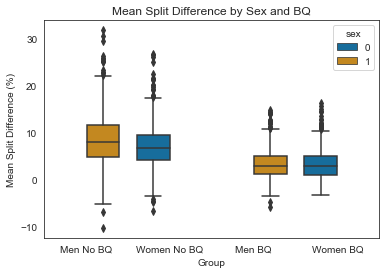

In [7]:
sns.set_style('white')
sns.set_palette('colorblind')

#Display boxplots in descending order of median value
plot_order = boston_exp.groupby('group')['split_diff'].median().sort_values(ascending=False).index.values
g = sns.boxplot(x = 'group', y = 'split_diff', hue = 'sex', data = boston_exp, order = plot_order)
g.set(title = 'Mean Split Difference by Sex and BQ', xlabel = 'Group', ylabel = 'Mean Split Difference (%)')
plt.show()

Based on the data we see above, BQ and sex might have an interactive effect on split strategy. More specifically, the effect of running a Boston qualifying time on split strategy is different for men than it is for women. Thus, we should look for an interaction effect when running our ANOVA. We can also see fairly large differences in variance between the four groups. We will look more closely at this a bit later.

For our ANOVA, we will test three separate null hypotheses:

* There is no difference in group means at either level of the sex variable.
* There is no difference in group means at either level of the bq variable.
* The effect of sex on split difference does not depend on the effect of running a Boston qualifying time.

We will use a significance (alpha) level of 1% for each of these hypotheses. That is, we will accept a 1% chance of a Type I error (i.e., erroneously rejecting each null hypothesis when it is actually true). Let's fit an ordinary least squares model to the experiment groups using statsmodels. We will have statsmodels regress "split_diff" on "bq", "sex", and the interaction of "bq" and "sex". We will use both the residuals and fitted values to test the ANOVA assumptions later, so let's to store those in variables for later use.

In [8]:
#Fit OLS model to Boston data
formula = 'split_diff ~ bq * sex'
fit = smf.ols(formula, data = boston_exp).fit()

#Store residuals and fitted values
resids = fit.resid
fitted_y = fit.fittedvalues

Before we actually run an ANOVA and interpret results, we should look at the assumptions that underlie the ANOVA model to see if it is appropriate for our data and if any remedial measures are necessary. There are three major assumptions we must satisfy in order for the ANOVA to be an effective model:

1. The distribution of the y variable (i.e., split difference) is normal within each group.
2. Each data point is independent and randomly sampled.
3. There is homogeneity of variance between each group.

While it isn't a formal assumption, we should also investigate whether there are any outliers that might be influencing the results of the ANOVA. We will look at each of these assumptions in the following section.

## Experiment Assumptions

### 1. Normality

One of the assumptions of ANOVA is that the distribution of the y variable (i.e., split difference) is normal within each group. One way to assess normality is with formal tests, such as the Shapiro-Wilk test. However, Shapiro-Wilk is overly sensitive to non-normality when the sample size is very large, as it is in our case, so it is not a good option.

Another useful way to assess normality is to look at a QQ plot of the residuals for each group. The red line represents a normal distribution of data, so the closer the residuals conform to the line, the more normal the distribution of residuals is.

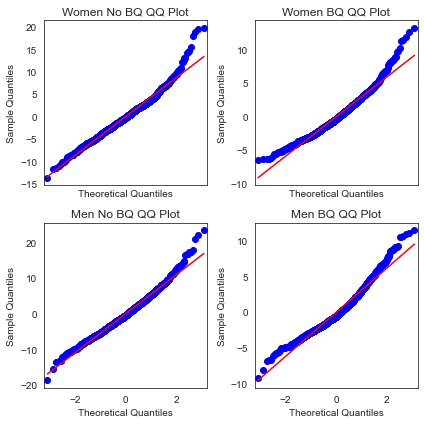

In [9]:
#Use a dictionary comprehension to group residuals by experiment group
resid_dict = {group: resids[resids.index.isin(boston_exp[boston_exp['group'] == group].index)]
              for group in boston_exp['group'].unique()}

#Plot residuals for each group on separate plots with a line representing a normal distribution
fig, axes = plt.subplots(ncols=2, nrows=2, sharex = True, figsize=(2*3, 2*3))                
for key, ax in zip(resid_dict, np.ravel(axes)):
    sm.qqplot(resid_dict[key], line = 's', ax=ax)
    ax.set_title(f'{key} QQ Plot')
plt.tight_layout()

These plots don't look perfectly normal, but they are pretty close. We can see some larger departures from normality at the ends of each chart, indicating some kurtosis. A slight U-shape, more noticeable on the BQ plots, indicates some skewness. We can also look at skewness and kurtosis values for each group directly to get a sense of normality.

In [10]:
for key in resid_dict:
    print(key + ' skew: {}'.format(skew(resid_dict[key], bias = False)))
    print(key + ' kurtosis: {}'.format(kurtosis(resid_dict[key], fisher = False, bias = False)))

Women No BQ skew: 0.5650549612911787
Women No BQ kurtosis: 4.550523682414709
Women BQ skew: 0.7905702199104852
Women BQ kurtosis: 4.196908499312302
Men No BQ skew: 0.4724290900037347
Men No BQ kurtosis: 3.7829483228101024
Men BQ skew: 0.7540223566801632
Men BQ kurtosis: 3.7377708654342876


A normal distribution would have a skew of 0 and kurtosis of 3, so these values are not huge departures from normality. Moreover, ANOVA is generally robust to departures from the assumption of normality. That is, the actual Type I error rate is still very close to the chosen significance level even when the data is moderately non-normal. If we were seeing wildly non-normal distributions, we might try to apply a transformation to the data, such as a log transformation, in order to make it more normal. However, that is probably unnecessary in our case. We will consider the assumption satisfied.

### 2. Independence and random sampling

The second assumption is that each data point is independent. That is, each observation appears only once in each sample and each sample was collected using random sampling. In our experiment the first part is easily satisfied. As for the second part, while we have certainly randomly sampled from runners 18-39 in the Boston Marathon who ran under 5 hours, we could reasonably question whether Boston Marathon runners represent a random sample of marathon runners as a whole. The Boston Marathon is a special race--runners must meet tough qualifying standards or raise large amounts of money for charity to run. This data also represents runners on a particular course on a particular day with particular weather, all factors which could reduce the randomness and independence of the data. Thus, we should probably be careful about generalizing the results of this project beyond the 2021 Boston Marathon. If we were to look at several years of results from the Boston Marathon, or aggregated results of several marathons, that would probably help alleviate any concerns about independence and random sampling.

### 3. Homogeneity of Variance

The last assumption is homogeneity of variance between each group. We already saw earlier that the variances of the groups were not the same. This can also be visualized by plotting the fitted values of the model against the residuals.

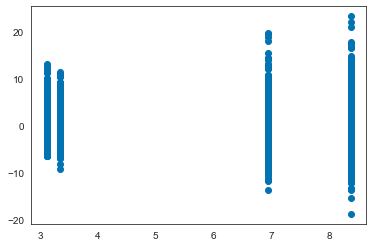

In [11]:
plt.scatter(fitted_y, resids)
plt.show()

There is clearly a "megaphone" shape to the plot, indicating that variance is increasing as mean split difference is increasing. 

But how much heterogeneity of variance is too much? ANOVA is robust to moderate heterogeneity of variance. In their book "Designing Experiments and Analyzing Data: A Model Comparison Perspective", Scott Maxwell, Harold Delaney, and Ken Kelley recommend a rule of thumb for experiments with equal sample size for each group. If the ratio of the largest group variance to the smallest group variance is greater than 4, then we should consider using an alternative method to analyze the data. Let's look again at the variance of split difference each group. 

In [12]:
boston_exp[['split_diff', 'group']].groupby(['group']).agg(np.var)

,split_diff
group,
Men BQ,9.59
Men No BQ,30.07
Women BQ,8.78
Women No BQ,18.91


We can see that the largest variance is 30.07 and the smallest is 8.78, which means the ratio is less than 4. So, we are probably okay proceeding with a regular ANOVA. If we were still concerned about homogeneity of variance, one option would be to fit a weighted least squares (WLS) model to the data instead of ordinary least squares (OLS) model. This would essentially assign weights to the data points when estimating the model. As an extra, an alternative analysis using weighted least squares has been included at the end of this notebook. The results of the weighted least squares analysis are not significantly different than the ordinary least squares analysis, indicating that the ordinary least squares analysis is indeed robust to some heterogeneity of variance.

### Outliers

While it isn't a formal assumption, we should consider whether any particular data points might be influencing the results of the test. An outlier is a y value that does not follow the general trend of the data. There are multiple ways to identify outliers, but one way that would work well for this experiment is to use the Tukey box plot method for each group. For each group, we define an inner fence at 1.5 times the interquartile range on the upper and lower ends and an outer fence at 3 times the interquartile range on the upper and lower ends. Any points between the inner and outer fences are considered "possible outliers" and any points beyond the outer fence are considered "probable outliers". Some of the advantages of this test are that it is relatively robust to outliers (i.e., finding one outlier is independent of other outliers) and that it does not require a normal distribution of data. I have adapted a function from a wonderful [blog post](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755) by Alicia Horsch to perform this task.

In [13]:
def tukey(df, col):
    """Takes a DataFrame and variable of interest, returns the runner_id of probable and possible outliers."""
    #Compute the IQR and inner and outer fences
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    inner_fence = 1.5 * iqr
    outer_fence = 3 * iqr
    
    #Compute inner fence lower and upper ends
    inner_fence_lower = q1 - inner_fence
    inner_fence_upper = q3 + inner_fence
    
    #Compute outer fence lower and upper ends
    outer_fence_lower = q1 - outer_fence
    outer_fence_upper = q3 + outer_fence
    
    #If value is an outlier, append the runner_id to the appropriate outlier list
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[col]):
        if x <= outer_fence_lower or x >= outer_fence_upper:
            outliers_prob.append(df.iloc[index]['runner_id'])
        elif x <= inner_fence_lower or x >= inner_fence_upper:
            outliers_poss.append(df.iloc[index]['runner_id'])
    return outliers_prob, outliers_poss

#For each experiment group, run the Tukey function and put the results in a dictionary
outlier_dict = {group: tukey(boston_exp[boston_exp['group'] == group], 'split_diff') 
                for group in boston_exp['group'].unique()}

#Print the possible and probable outliers for each group
for key in outlier_dict:
    print(key + ' probable outliers: {}'.format(outlier_dict[key][0]))
    print(key + ' possible outliers: {}'.format(outlier_dict[key][1]))

Women No BQ probable outliers: [8296, 9724, 6871]
Women No BQ possible outliers: [4658, 19336, 6224, 19216, 7001, 18337, 8413, 8406, 7439, 6782, 11135, 8542, 9014, 16026, 9119, 5178, 9079]
Women BQ probable outliers: []
Women BQ possible outliers: [5000, 5589, 6281, 5361, 5009, 6037, 6213, 5828, 6768, 4751, 3009, 4803, 150, 6952, 827, 1290, 4965, 7319, 7435, 6063]
Men No BQ probable outliers: []
Men No BQ possible outliers: [17134, 871, 1924, 1365, 339, 16897, 1103, 2149, 18485, 1638, 1069, 1767, 4006, 2389, 1599]
Men BQ probable outliers: []
Men BQ possible outliers: [795, 2187, 726, 274, 433, 1380, 377, 1370, 918, 940, 908, 2044, 2071, 2745, 759, 594, 565, 344, 3271, 962, 848, 2422, 1181, 657]


The function only identified three runners as probable outliers, while it identified many more as possible outliers. So now the question is: what do we do about them? The identification and treatment of outliers is somewhat subjective. Once outliers are identified, we could keep them, drop them, recode them with a different value, transform our data to reduce their impact, or use a different method or model to analyze the data that is more robust to outliers. What we decide to do depends largely on domain knowledge and why exactly the value is appearing as an outlier. As a general rule, we should not drop or alter outliers without a good objective reason, and we should not drop or alter them simply because they do not fit our model. If we could show that any outliers were clearly the result of error, or are not a part of the population of interest in our experiment, that would be a good reason to drop or alter them. However, the outliers might also contain clues about shortcomings of the model. So, a good first step would be to more closely examine the outliers. Let's first look at the three probable outliers.

In [14]:
prob_outliers = boston_exp[boston_exp['runner_id'].isin(outlier_dict['Women No BQ'][0])]
prob_outliers

,place_overall,place_sex,place_division,sex,runner_id,country,last_name,first_name,finish_hours,first_half_hours,second_half_hours,split_diff,bq,group
52,12512,5791,2233,0,8296,United States,Decarpentrie,Sarah,4.56,1.68,2.88,26.42,0,Women No BQ
245,13376,6295,2398,0,9724,United States,Medina,Gabriela,4.82,1.79,3.04,25.94,0,Women No BQ
743,12257,5641,2189,0,6871,United States,Folsom,Ashley,4.49,1.64,2.84,26.76,0,Women No BQ


These are all women running about 4.5-5 hour times who ran a significantly slower second half than first half. We don't have enough information to determine if there was a measurement or data entry error, so we must assume the times are all correct. A time of around three hours for the second half split corresponds to an average speed of about 4.37 mph, or about 13:44/mile. It's possible that these runners walked significant portions of the second half, especially if they ran the first half in under two hours, but we cannot even really be sure of that. It's entirely plausible that they simply ran the first half too fast and had to slow down for the second half, which would make them of interest for this experiment. Moreover, because these are only three points out of several thousand, dropping or altering them likely won't change the results. Thus, the safest thing to do would be to keep them in the experiment as is.

We can also look at the possible outliers, though the reasoning above very likely holds for them too.

In [15]:
poss_list = outlier_dict['Women No BQ'][1] + outlier_dict['Women BQ'][1] \
+ outlier_dict['Men No BQ'][1] + outlier_dict['Men BQ'][1]

poss_outliers = boston_exp[boston_exp['runner_id'].isin(poss_list)]

#Display all rows instead of truncated list
pd.options.display.max_rows = None

poss_outliers

,place_overall,place_sex,place_division,sex,runner_id,country,last_name,first_name,finish_hours,first_half_hours,second_half_hours,split_diff,bq,group
15,7228,2630,1464,0,4658,NaN,Taylor,Carrie,3.70,1.49,2.20,19.19,0,Women No BQ
80,12805,5955,2281,0,19336,United States,Rowell,Mia,4.64,2.43,2.21,-4.75,0,Women No BQ
84,11242,5061,2063,0,6224,United States,Maldarelli,Claire,4.26,1.71,2.55,19.66,0,Women No BQ
123,9688,4110,1847,0,19216,United States,Borofski,Katrina,4.00,2.09,1.91,-4.51,0,Women No BQ
220,12137,5577,2174,0,7001,United States,Peeters,Sophie,4.46,1.75,2.70,21.32,0,Women No BQ
225,13459,6339,2413,0,18337,United States,Rothman,Cara,4.86,2.00,2.85,17.49,0,Women No BQ
255,11555,5231,2104,0,8413,United States,Howe,Katie,4.33,1.75,2.58,19.10,0,Women No BQ
257,11192,5033,2056,0,8406,United States,Gloude,Chelsey,4.25,1.67,2.58,21.50,0,Women No BQ
323,10075,4355,1908,0,7439,United States,Cannon,Claire,4.07,1.67,2.40,17.88,0,Women No BQ
350,12569,5826,2243,0,6782,United States,Berge,Tyler,4.58,1.88,2.69,17.71,0,Women No BQ


In [16]:
#Revert back to only displaying 10 rows
pd.options.display.max_rows = 10

Again, these are all perfectly plausible splits, and there is no obvious error. While there are significantly more possible outliers than probable outliers, there are still relatively few compared to the overall sample size. Overall, there isn't a compelling reason to not keep the outliers as is.

## ANOVA Results

Now that we have examined the assumptions underlying ANOVA, let's look at the ANOVA results. We will also print the regression summary because it contains confidence intervals and other useful statistics.

In [17]:
#Run ANOVA on fitted model
aov_table = sm.stats.anova_lm(fit, typ=3)

#Print ANOVA table
print("ANOVA Table")
print(aov_table)
print()
print(fit.summary(alpha = 0.01))
print()

ANOVA Table
            sum_sq      df       F  PR(>F)
Intercept 47417.87    1.00 2816.28    0.00
bq         7209.16    1.00  428.17    0.00
sex        1005.32    1.00   59.71    0.00
bq:sex      350.03    1.00   20.79    0.00
Residual  66203.23 3932.00     NaN     NaN

                            OLS Regression Results                            
Dep. Variable:             split_diff   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     401.8
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          1.22e-227
Time:                        15:28:16   Log-Likelihood:                -11140.
No. Observations:                3936   AIC:                         2.229e+04
Df Residuals:                    3932   BIC:                         2.231e+04
Df Model:                           3                                         
Covariance Type:  

The main effect of BQ is statistically significant at the alpha = 1% level (F(1, 3932) = 428.17, p = 0.00). The main effect of sex is also statistically significant (F(1, 3932) = 59.71, p = 0.00). And importantly, the interaction of BQ and sex is also statistically significant (F(1, 3932) = 20.79, p = 0.00). Since we have a statistically significant interaction, we can reject the null hypothesis that the effect of sex on split difference does not depend on the effect of running a Boston qualifying time. However, we should further run a simple effects analysis to get a better idea of how significant BQ and sex are individually. To do this we will run a series of one-way ANOVAs, first holding sex constant and looking at the significance of BQ, then holding BQ constant and looking at the significance of sex.

In [18]:
#Group data by sex
boston_men = boston_exp[boston_exp['sex'] == 1]
boston_women = boston_exp[boston_exp['sex'] == 0]

#Fit OLS model to Boston men data
formula = 'split_diff ~ bq'
fit_men = smf.ols(formula, data = boston_men).fit()

#Run ANOVA on fitted model
aov_table_men = sm.stats.anova_lm(fit_men, typ=3)

#Print ANOVA table
print("ANOVA Table Men")
print(aov_table_men)
print()
print(fit_men.summary(alpha = 0.01))
print()

#Fit OLS model to Boston women data
formula = 'split_diff ~ bq'
fit_women = smf.ols(formula, data = boston_women).fit()

#Run ANOVA on fitted model
aov_table_women = sm.stats.anova_lm(fit_women, typ=3)

#Print ANOVA table
print("ANOVA Table Women")
print(aov_table_women)
print()
print(fit_women.summary(alpha = 0.01))
print()

ANOVA Table Men
            sum_sq      df       F  PR(>F)
Intercept 68956.93    1.00 3477.01    0.00
bq        12402.24    1.00  625.36    0.00
Residual  38990.18 1966.00     NaN     NaN

                            OLS Regression Results                            
Dep. Variable:             split_diff   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     625.4
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          4.55e-120
Time:                        15:28:16   Log-Likelihood:                -5731.0
No. Observations:                1968   AIC:                         1.147e+04
Df Residuals:                    1966   BIC:                         1.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef

Here we can see that the effect of running a Boston qualifying time is significant for both men (F(1, 1966) = 625.36, p = 0.00) and women (F(1, 1966) = 520.82, p = 0.00) at alpha = 1%. Thus, we can reject the null hypothesis of no difference in group means at either level of the BQ variable for runners of either sex. Now let's look at the effect of sex.

In [19]:
#Group data by BQ
boston_bq = boston_exp[boston_exp['bq'] == 1]
boston_nobq = boston_exp[boston_exp['bq'] == 0]

#Fit OLS model to Boston BQ data
formula = 'split_diff ~ sex'
fit_bq = smf.ols(formula, data = boston_bq).fit()

#Run ANOVA on fitted model
aov_table_bq = sm.stats.anova_lm(fit_bq, typ=3)

#Print ANOVA table
print("ANOVA Table BQ")
print(aov_table_bq)
print()
print(fit_bq.summary(alpha = 0.01))
print()

#Fit OLS model to Boston no BQ data
formula = 'split_diff ~ sex'
fit_nobq = smf.ols(formula, data = boston_nobq).fit()

#Run ANOVA on fitted model
aov_table_nobq = sm.stats.anova_lm(fit_nobq, typ=3)

#Print ANOVA table
print("ANOVA Table No BQ")
print(aov_table_nobq)
print()
print(fit_nobq.summary(alpha = 0.01))
print()

ANOVA Table BQ
            sum_sq      df       F  PR(>F)
Intercept  9541.41    1.00 1038.82    0.00
sex          27.54    1.00    3.00    0.08
Residual  18057.41 1966.00     NaN     NaN

                            OLS Regression Results                            
Dep. Variable:             split_diff   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.999
Date:                Tue, 12 Apr 2022   Prob (F-statistic):             0.0835
Time:                        15:28:16   Log-Likelihood:                -4973.5
No. Observations:                1968   AIC:                             9951.
Df Residuals:                    1966   BIC:                             9962.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

Now we can see that the effect of sex is actually NOT significant for runners who run a Boston qualifying time (F(1, 1966) = 3, p = 0.08), while it is significant for runners who didn't run a Boston qualifying time (F(1, 1966) = 41.05, p = 0.00). Thus, we cannot reject the null hypthesis of no difference in group means at either level of the sex variable, but only for runners who run a Boston qualifying time. For runners who didn't run a Boston qualifying time, we can reject the null hypothesis.

## Effect Size

While the ANOVA tells us which effects are statistically significant, it does not tell us the size of each effect. One common way of measuring effect size is Cohen's D, or the standardized mean difference. Cohen's D is calculated by taking the absolute difference in means between two samples of data and dividing it by the pooled standard deviation of the two samples. The result is a number indicating by how many standard deviations the means of the two samples differ. For example, a Cohen's D of 1 indicates that the means differ by one standard deviation.

Let's calculate Cohen's D for the difference between Men No BQ and Men BQ, Women No BQ and Women BQ, and Women No BQ and Men No BQ. Since there is no statistically significant difference between Men BQ and Women BQ, we will skip that.

In [20]:
#Divide split difference values into four groups by experiment group
boston_WNoBQ = boston_exp[boston_exp['group'] == 'Women No BQ']['split_diff']
boston_WBQ = boston_exp[boston_exp['group'] == 'Women BQ']['split_diff']
boston_MNoBQ = boston_exp[boston_exp['group'] == 'Men No BQ']['split_diff']
boston_MBQ = boston_exp[boston_exp['group'] == 'Men BQ']['split_diff']


def cohens_d(sampleA, sampleB):
    """Takes two sample arrays, computes Cohen's D and returns result."""
    diff = np.abs(np.mean(sampleA) - np.mean(sampleB))
    pooled_std = np.sqrt((np.std(sampleA)**2 + np.std(sampleB)**2)/2)
    result = diff/pooled_std
    return result

effect_BQonM = cohens_d(boston_MNoBQ, boston_MBQ)
effect_BQonW = cohens_d(boston_WNoBQ, boston_WBQ)
effect_MonNoBQ = cohens_d(boston_WNoBQ, boston_MNoBQ)

print("Effect size of BQ on men: {}".format(effect_BQonM))
print("Effect size of BQ on women: {}".format(effect_BQonW))
print("Effect size of men on no BQ: {}".format(effect_MonNoBQ))

Effect size of BQ on men: 1.1279826859661675
Effect size of BQ on women: 1.0293985807286112
Effect size of men on no BQ: 0.2890027067281681


The results here indicate large effect sizes for BQ on both men and women (1.13 and 1.03 standard deviations, respectively). That is, the difference in split times as a percentage of total finish time is 1.13 standard deviations smaller for men who ran a Boston qualifying time than for men who didn't run a Boston qualifying time. And the split difference is 1.03 standard deviations smaller for women who ran a Boston qualifying time than for women who didn't run a Boston qualifying time. Those are both very large differences. The effect size of sex on runners who didn't run a Boston qualifying time is much smaller at 0.29 standard deviations. That is, the split difference for women who didn't run a Boston qualifying time is 0.29 standard deviations less than men who didn't run a Boston qualifying time.

## Power Analysis

Statistical power is the probability of detecting an effect when there is in fact a true effect to detect. That is, it is the probability that a statistical test correctly rejects the null hypothesis. Given an effect size, an alpha level, and a sample size, we can calculate this probability for our experiment. We will use statsmodels to calculate the power for an experiment with 984 observations per group at the 1% significance level with an effect size of 0.29, the smallest effect detected in our experiment.

In [21]:
analysis = power.FTestAnovaPower()
pwresult = analysis.solve_power(effect_size = 0.29, power = None, alpha = 0.01, nobs = 984)
print(pwresult)

0.9999999999613354


The power for this experiment is very high, with over a 99.99999999% chance that we have correctly rejected the null hypotheses.

## Conclusion

We performed a 2x2 factorial ANOVA to compare the effects of sex and running a Boston qualifying marathon time on pace strategy, expressed as the difference between the second and first half splits as a percentage of overall finish time, for runners age 18-39 who finished the 2021 Boston Marathon faster than five hours.

The ANOVA revealed that there was a statistically significant interaction between the effects of sex and running a Boston qualifying time (F(1, 3932) = 20.79, p = 0.00).

Simple main effects analysis showed that running a Boston qualifying time had a statistically significant effect on split difference for both men (p = 0.00) and women (p = 0.00). The effect sizes of running a Boston qualifying time on men and women were 1.13 and 1.03 standard deviations, respectively. That is, men and women who ran BQ times ran split differences that were 1.13 and 1.03 standard deviations lower respectively than men and women who didn't run BQ times.

Simple main effects analysis showed that sex did not have a statistically significant effect on split difference for runners who ran a Boston qualifying time (p = 0.08), but did have a statistically significant effect for runners who did not run a Boston qualifying time (p = 0.00). The effect size of being male on runners who did not run a Boston qualifying time was 0.29 standard deviations.

A major limitation of this project is the uniqueness of both the Boston Marathon in general and the 2021 Boston Marathon in particular. A larger amount of data, either from more runnings of the Boston Marathon or from a wider cross-section of marathons, would help to determine whether these results hold up generally across all marathons. Another major limitation of this experiment is looking only at runner age 18-39. An interesting follow up to this experiment would be to run a similar experiment on a larger selection of data and also examine the effects of age on pace strategy.

## EXTRA: Weighted Least Squares

In situations where we might question whether we have enough homogeneity of variance to run an ordinary least squares ANOVA, one alternative option is running a weighted least squares ANOVA. In weighted least squares, we apply weights to the variances of the residuals to balance out differences in variance between groups. Because we know the residuals of the ordinary least squares model, we can compute weights for each group of residuals that are equal to 1/var(resids_i) for i = 1, 2, 3, and 4, where resids_i is the set of residuals for each group in the experiment.

In [22]:
#Initialize an empty dictionary to hold the weights
weight_dict = {}

#For each group in the residuals dictionary, compute the weight and store it in the dictionary
for key in resid_dict:
    weight_dict[key] = 1/np.var(resid_dict[key])

Now that we have a dictionary of weights, let's add a "weight" column to the experiment DataFrame and assign the appropriate weight to each data point.

In [23]:
for group in boston_exp['group'].unique():
    boston_exp.loc[boston_exp['group'] == group, 'weight'] = weight_dict[group]

Using the same general formula as in the ordinary least squares example, we can fit a weighted least squares model to the data using the weights we computed.

In [24]:
#Fit WLS model to Boston data
formula = 'split_diff ~ bq * sex'
wls_fit = smf.wls(formula, data = boston_exp, weights = boston_exp['weight']).fit()

#Store residuals and fitted values
wls_resids = wls_fit.resid
wls_fitted_y = wls_fit.fittedvalues

#Run ANOVA on fitted model
wls_aov_table = sm.stats.anova_lm(wls_fit, typ=3)

#Print ANOVA table
print("Weighted Least Squares ANOVA Table")
print(wls_aov_table)
print()
print(wls_fit.summary(alpha = 0.01))
print()

Weighted Least Squares ANOVA Table
           sum_sq      df       F  PR(>F)
Intercept 2510.39    1.00 2507.84    0.00
bq         521.35    1.00  520.82    0.00
sex         41.09    1.00   41.05    0.00
bq:sex      20.81    1.00   20.79    0.00
Residual  3936.00 3932.00     NaN     NaN

                            WLS Regression Results                            
Dep. Variable:             split_diff   R-squared:                       0.226
Model:                            WLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     383.5
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          1.83e-218
Time:                        15:28:16   Log-Likelihood:                -10885.
No. Observations:                3936   AIC:                         2.178e+04
Df Residuals:                    3932   BIC:                         2.180e+04
Df Model:                           3                                         
C

Notice that the coefficients in the regression table (i.e., the means for each group) are exactly the same, but the standard errors and confidence intervals are different. The weighted least squares model generally gives up better estimates of the confidence intervals. Notice also that the sums of squares in the ANOVA table are much lower for the weighted least squares model than the ordinary least squares model. This is because we weighted each residual to compensate for differences in variance.

To check whether we have applied the right weights, we can compute the standardized residuals for the weighted least squares model and plot them against the fitted values. If we did the weights correctly, we should see that each group has a similar variance.

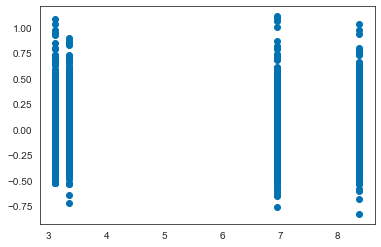

In [25]:
def standardized_resids(resids, sample_size):
    """Takes a set of residuals and sample size, computes standardized residuals."""
    resids_ss = np.sum(resids**2)
    resids_std = np.sqrt(resids_ss/(sample_size - 2))
    result = resids/resids_std
    return result

standardized_resids = standardized_resids(wls_resids, 3936)

#Multiply each standardized residual by 1/sqrt(weight) for that residual
wls_standardized_resids = []
for index, x in enumerate(boston_exp['weight']):
    wls_standardized_resids.append(standardized_resids[index] * np.sqrt(x))

#Create a DataFrame matching standardized residuals to fitted values and show a plot
df = pd.DataFrame({'wls_fitted_y':wls_fitted_y, 'wls_standardized_resids':wls_standardized_resids})
plt.scatter(df['wls_fitted_y'], df['wls_standardized_resids'])
plt.show()

The spread of residuals for each group now looks almost the same.

The p-values and confidence intervals we got for the results of the weighted least squares ANOVA were almost exactly the same as with ordinary least squares. But as with ordinary least squares, we should perform a simple effects analysis to see if there are any differences in the main effects of BQ and sex.

In [26]:
#Group data by sex
boston_men = boston_exp[boston_exp['sex'] == 1]
boston_women = boston_exp[boston_exp['sex'] == 0]

#Fit WLS model to Boston men data
formula = 'split_diff ~ bq'
wls_fit_men = smf.wls(formula, data = boston_men, weights = boston_men['weight']).fit()

#Run ANOVA on fitted model
wls_aov_table_men = sm.stats.anova_lm(wls_fit_men, typ=3)

#Print ANOVA table
print("Weighted Least Squares ANOVA Table Men")
print(wls_aov_table_men)
print()
print(wls_fit_men.summary(alpha = 0.01))
print()

#Fit WLS model to Boston women data
formula = 'split_diff ~ bq'
wls_fit_women = smf.wls(formula, data = boston_women, weights = boston_women['weight']).fit()

#Run ANOVA on fitted model
wls_aov_table_women = sm.stats.anova_lm(wls_fit_women, typ=3)

#Print ANOVA table
print("Weighted Least Squares ANOVA Table Women")
print(wls_aov_table_women)
print()
print(wls_fit_women.summary(alpha = 0.01))
print()

Weighted Least Squares ANOVA Table Men
           sum_sq      df       F  PR(>F)
Intercept 2295.50    1.00 2293.17    0.00
bq         625.99    1.00  625.36    0.00
Residual  1968.00 1966.00     NaN     NaN

                            WLS Regression Results                            
Dep. Variable:             split_diff   R-squared:                       0.241
Model:                            WLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     625.4
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          4.55e-120
Time:                        15:28:16   Log-Likelihood:                -5578.5
No. Observations:                1968   AIC:                         1.116e+04
Df Residuals:                    1966   BIC:                         1.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
  

Again, the p-values match what we got with ordinary least squares, and the confidence intervals are very close.

In [27]:
#Group data by BQ
boston_bq = boston_exp[boston_exp['bq'] == 1]
boston_nobq = boston_exp[boston_exp['bq'] == 0]

#Fit WLS model to Boston BQ data
formula = 'split_diff ~ sex'
wls_fit_bq = smf.wls(formula, data = boston_bq, weights = boston_bq['weight']).fit()

#Run ANOVA on fitted model
wls_aov_table_bq = sm.stats.anova_lm(wls_fit_bq, typ=3)

#Print ANOVA table
print("Weighted Least Squares ANOVA Table BQ")
print(wls_aov_table_bq)
print()
print(wls_fit_bq.summary(alpha = 0.01))
print()

#Fit WLS model to Boston no BQ data
formula = 'split_diff ~ sex'
wls_fit_nobq = smf.wls(formula, data = boston_nobq, weights = boston_nobq['weight']).fit()

#Run ANOVA on fitted model
wls_aov_table_nobq = sm.stats.anova_lm(wls_fit_nobq, typ=3)

#Print ANOVA table
print("Weighted Least Squares ANOVA Table No BQ")
print(wls_aov_table_nobq)
print()
print(wls_fit_nobq.summary(alpha = 0.01))
print()

Weighted Least Squares ANOVA Table BQ
           sum_sq      df       F  PR(>F)
Intercept 1088.35    1.00 1087.24    0.00
sex          3.00    1.00    3.00    0.08
Residual  1968.00 1966.00     NaN     NaN

                            WLS Regression Results                            
Dep. Variable:             split_diff   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.999
Date:                Tue, 12 Apr 2022   Prob (F-statistic):             0.0835
Time:                        15:28:16   Log-Likelihood:                -4972.6
No. Observations:                1968   AIC:                             9949.
Df Residuals:                    1966   BIC:                             9960.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
   

Again, we get the same p-values and almost the same confidence intervals as ordinary least squares. Given that weighted least squares gives the same essential results as ordinary least squares, ordinary least squares is sufficient for this project, though it is still a good idea to check anyway.